# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [52]:
#The goal is to understand key factors that influence the prices of used cars. This could help dealerships, buyers and sellers and market analysts to make informed decisions.
#Key Questions to address:
#1. What are the most significant factors that influence the price of a used cars?
#2. What is the relationship between the age, mileage, brand, and condition of a car and its price?
#3. Can we predict the price of a used car based on its age, mileage, brand, and condition?
#4. How does a car's brand influence its price?
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format #to display numbers in 2 decimal places for readability

df = pd.read_csv("vehicles.csv")
df.head(10) #lots of data is missing in the dataset

print(f'Shape of dataset is: {df.shape}')  #there are 18 features or columns in the dataset 426,880 rows
print(f'Dataset Summary: \n {df.describe(include='all')}') #to get a summary of the dataset



Shape of dataset is: (426880, 18)
Dataset Summary: 
                   id    region         price      year manufacturer   model condition    cylinders    fuel    odometer title_status transmission                VIN   drive       size    type paint_color   state
count      426880.00    426880     426880.00 425675.00       409234  421603    252776       249202  423867   422480.00       418638       424324             265838  296313     120519  334022      296677  426880
unique           NaN       404           NaN       NaN           42   29649         6            8       5         NaN            6            3             118246       3          4      13          12      51
top              NaN  columbus           NaN       NaN         ford   f-150      good  6 cylinders     gas         NaN        clean    automatic  1FMJU1JT1HEA52352     4wd  full-size   sedan       white      ca
freq             NaN      3608           NaN       NaN        70985    8009    121456        94169  356

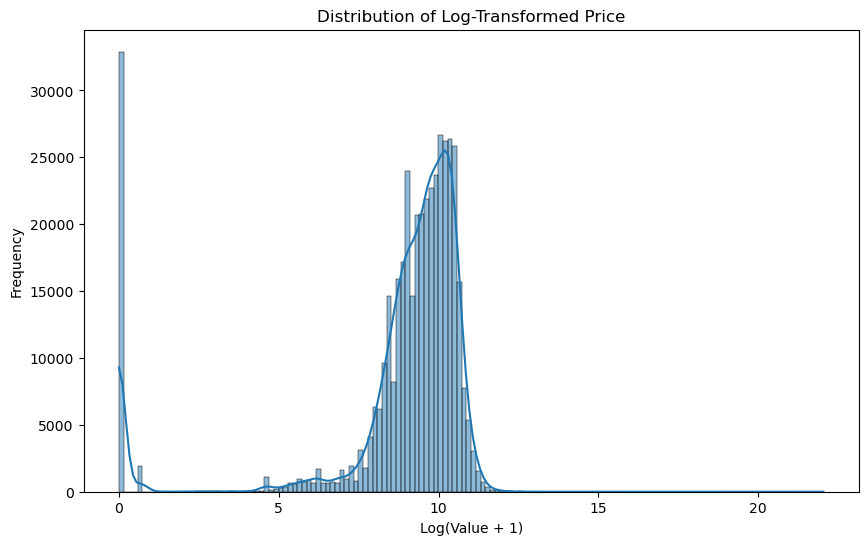

In [53]:
#After many attempts at plotting the price data to understand the distribution, log transformation was used for a visual representation 
variable = 'price'
df['log_variable'] = np.log1p(df[variable]) # log1p handles zero and negative values safely
plt.figure(figsize=(10, 6))
sns.histplot(df['log_variable'], bins=150, kde=True)
plt.title(f'Distribution of Log-Transformed {variable.capitalize()}')
plt.xlabel('Log(Value + 1)')
plt.ylabel('Frequency')
plt.show()
#Graphing the distribution of the price data where we the data is highly skwed to the left. Also there are many zero values or close to zero which is unrealistic and will be addressed


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

Percentage of missing values in each column:
size           71.77
cylinders      41.62
condition      40.79
VIN            37.73
drive          30.59
paint_color    30.50
type           21.75
manufacturer    4.13
title_status    1.93
model           1.24
odometer        1.03
fuel            0.71
transmission    0.60
year            0.28
state           0.00
id              0.00
region          0.00
price           0.00
log_variable    0.00
dtype: float64


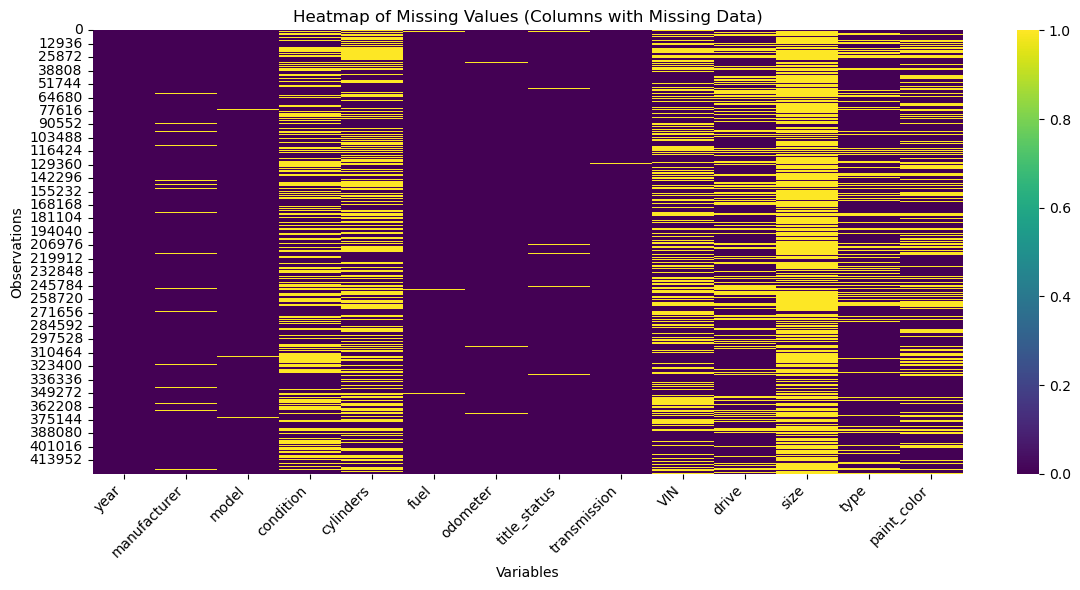

In [54]:
#The data data summary shows many missing values need to get a better understanding of the missing values
missing_counts  = df.isnull().sum()
total_entries = len(df)
missing_percent = (missing_counts / total_entries) * 100

print("Percentage of missing values in each column:")
print(missing_percent.sort_values(ascending=False))
'''
Top colums with missing values are below and visible in the heatmap
size           71.77
cylinders      41.62
condition      40.79
VIN            37.73
drive          30.59
paint_color    30.50
type           21.75
'''
cols_with_missing = df.columns[df.isnull().any()].tolist()
plt.figure(figsize=(12, 6))
sns.heatmap(df[cols_with_missing].isnull(), cbar=True, cmap='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Heatmap of Missing Values (Columns with Missing Data)')
plt.xlabel('Variables')
plt.ylabel('Observations')
plt.tight_layout()
plt.show()

In [55]:
#There are 32,895 cars with zero price which is unrealistic. Dropping rows where car price is less than 900 after searching online for cheapest used car price https://www.cars.com/shopping/results/?city_name=New+York%2C+NY&city_slug[]=new_york-ny&list_price_max=5000&list_price_min=0&sort=list_price&stock_type=used&zip=11221 
print(f'Zero priced car count: {df['price'].eq(0).sum()}') #Zero priced car count: 32,895
df = df[df['price'] > 900] #Remove zero priced cars from the dataset since this is not realistic

#Dropping rows where price is not affected and log_variable column that was created for visualization
df.drop(columns=['id', 'VIN','log_variable'], inplace=True)
df.describe(include='all')


Zero priced car count: 32895


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
count,380983,380983.00,379818.00,365779,376494,237412,225563,378391,378887.00,374352,379166,265555,107543,299604,271867,380983
unique,404,NaN,NaN,42,27263,6,8,5,NaN,6,3,3,4,13,12,51
top,columbus,NaN,NaN,ford,f-150,good,6 cylinders,gas,NaN,clean,automatic,4wd,full-size,sedan,white,ca
freq,3308,NaN,NaN,63358,6893,118315,86050,318959,NaN,361478,295456,116230,56535,77551,71649,43593
mean,NaN,84246.99,2010.98,NaN,NaN,NaN,NaN,NaN,98232.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,12895192.42,9.61,NaN,NaN,NaN,NaN,NaN,186187.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,902.00,1900.00,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,7980.00,2008.00,NaN,NaN,NaN,NaN,NaN,38177.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,15990.00,2013.00,NaN,NaN,NaN,NaN,NaN,87656.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,27990.00,2017.00,NaN,NaN,NaN,NaN,NaN,136000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


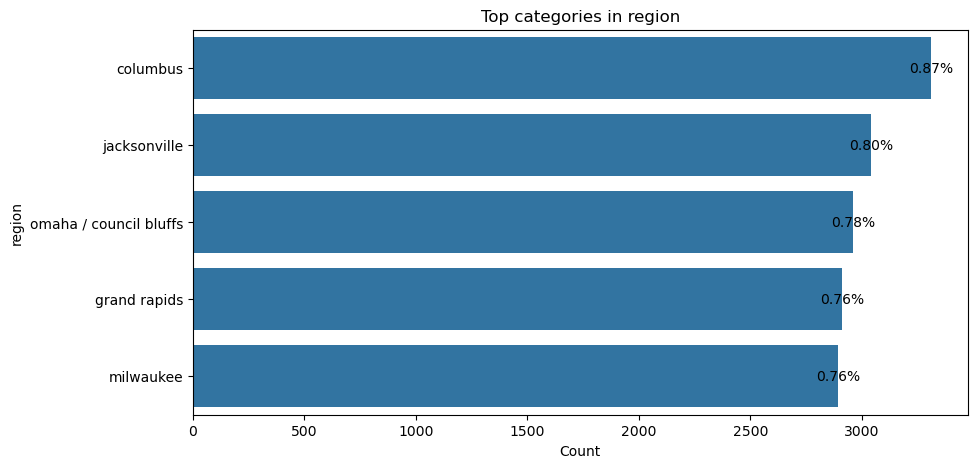

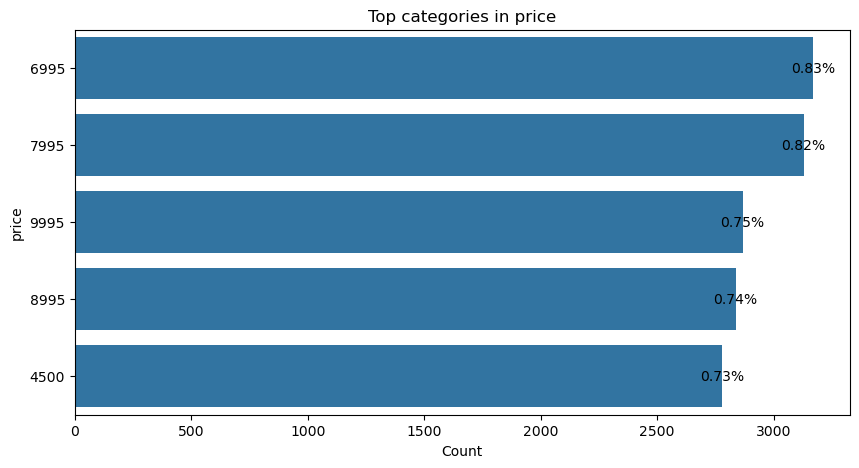

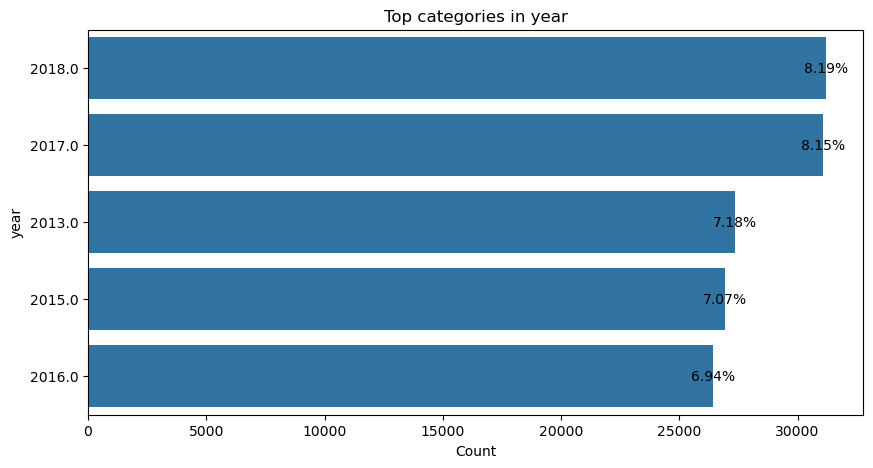

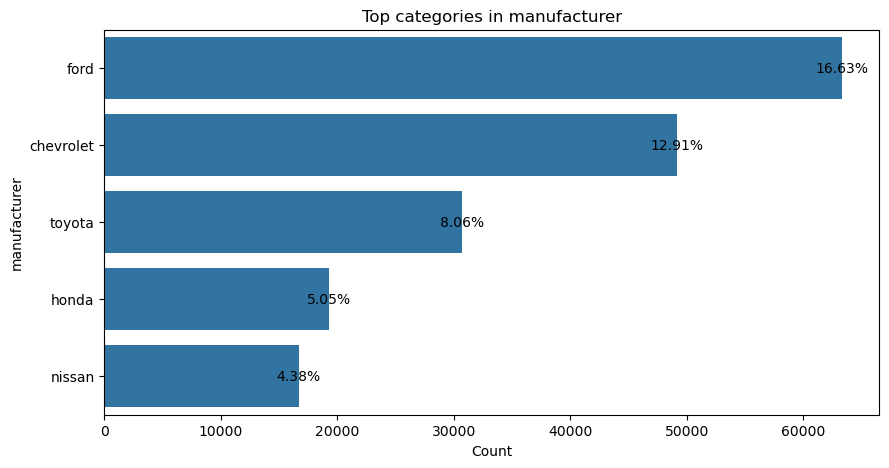

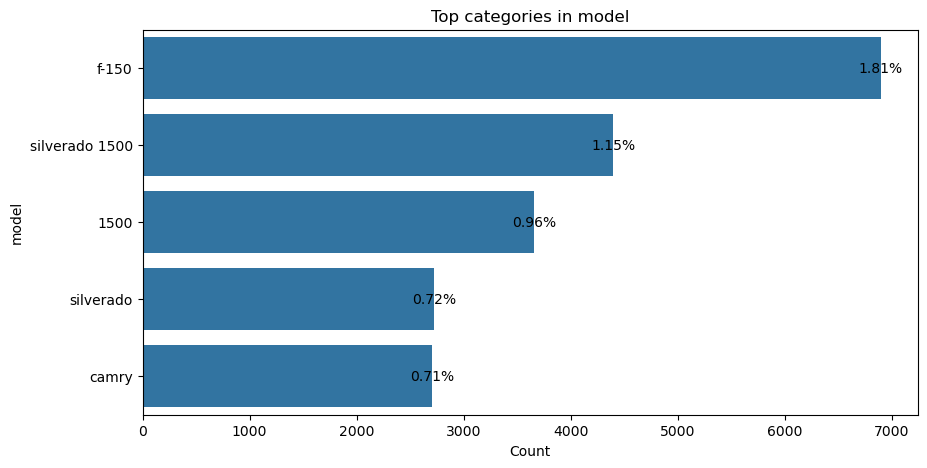

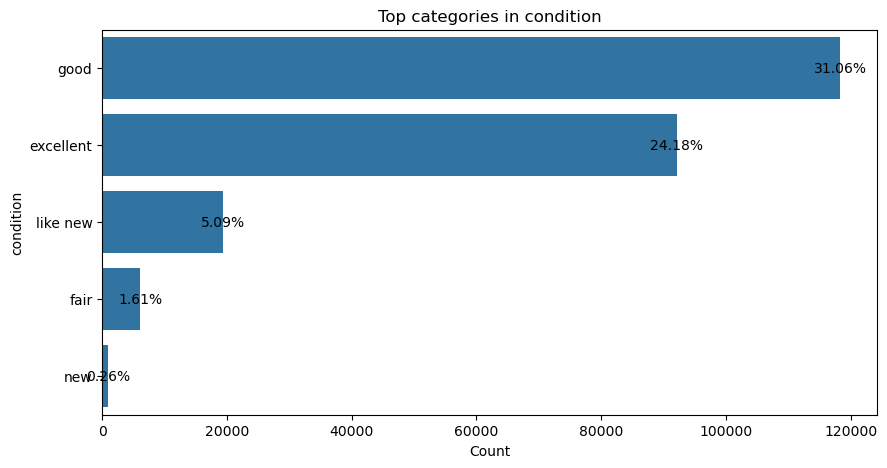

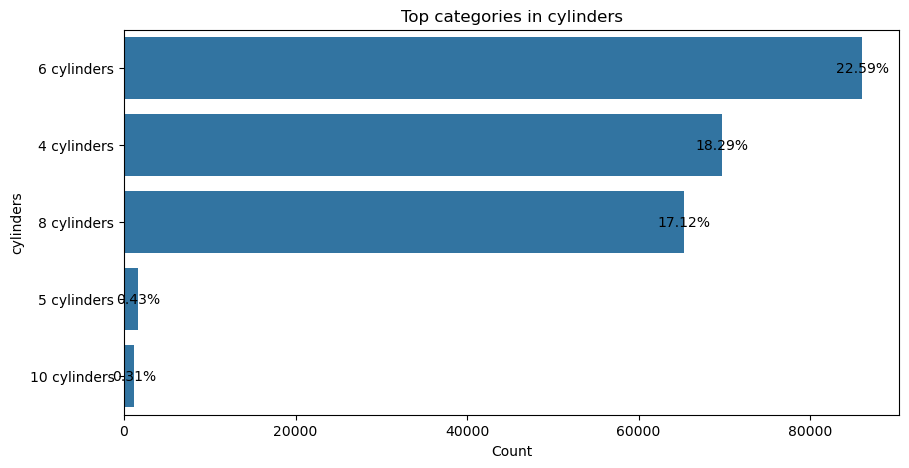

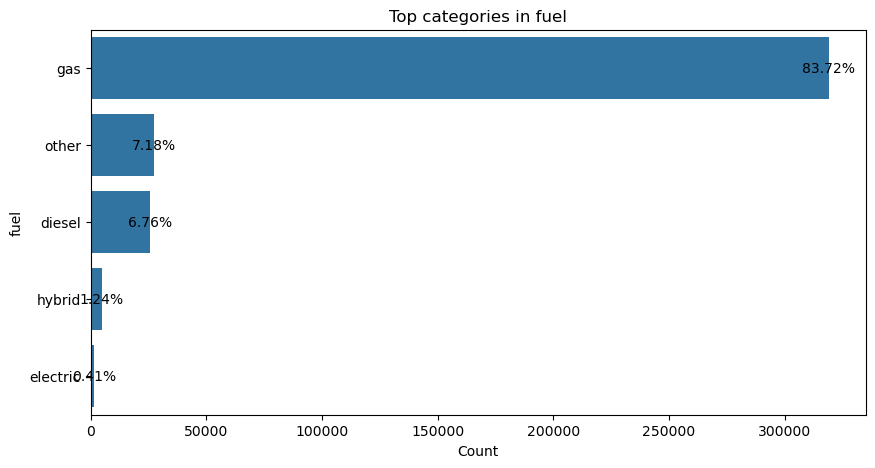

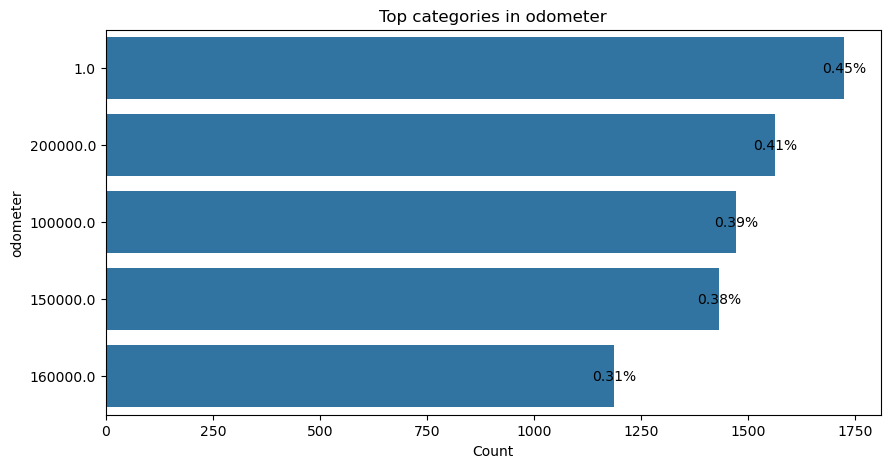

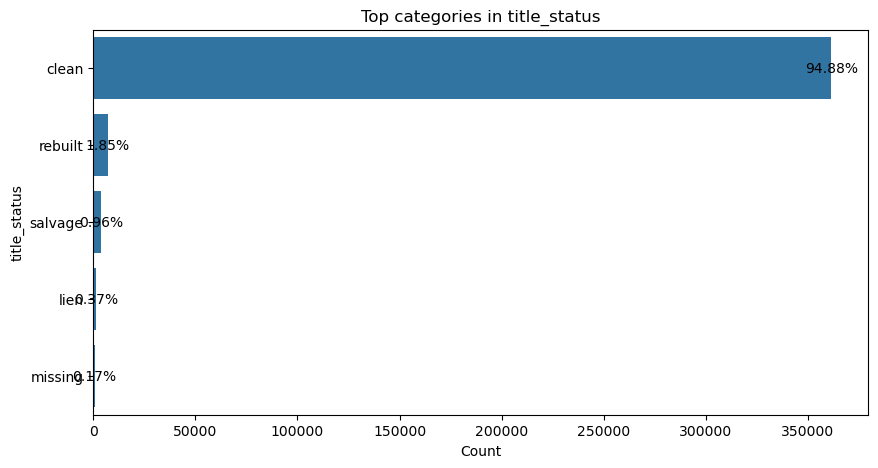

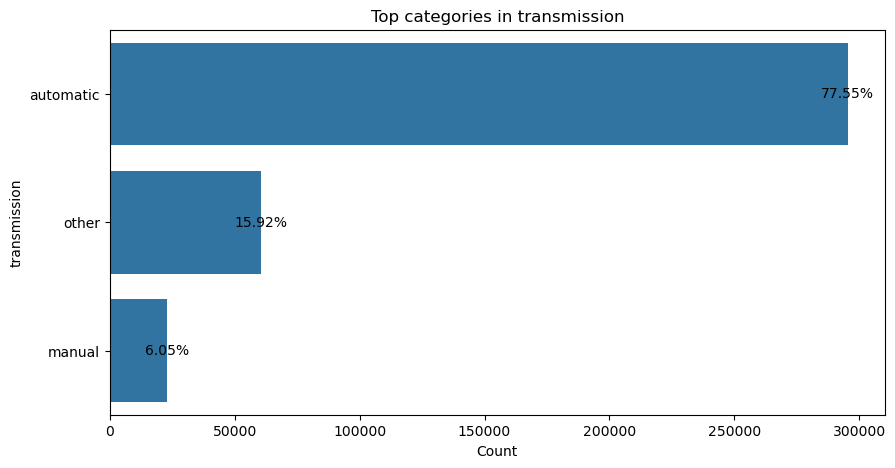

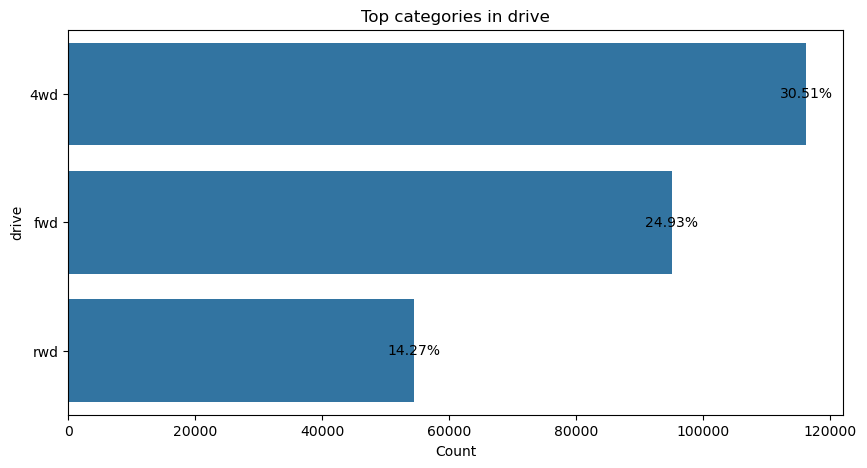

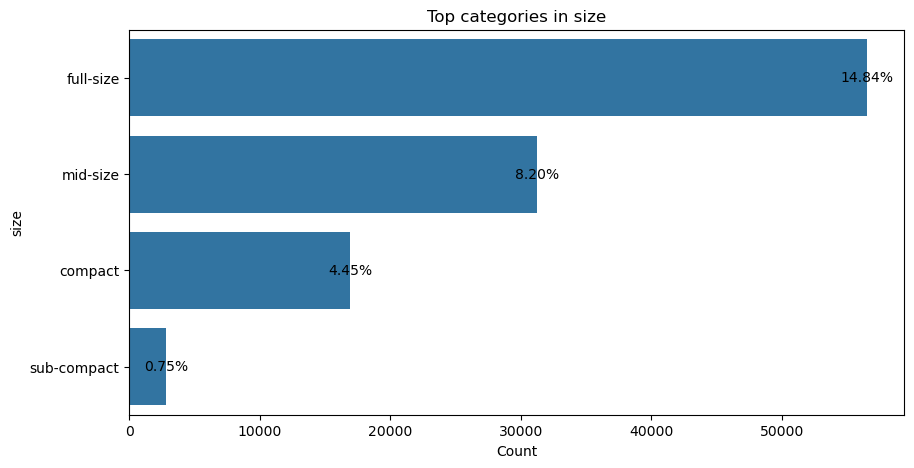

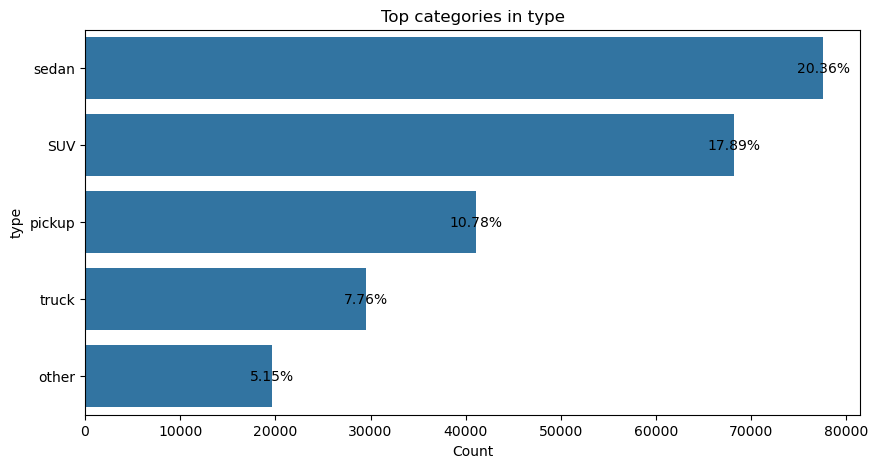

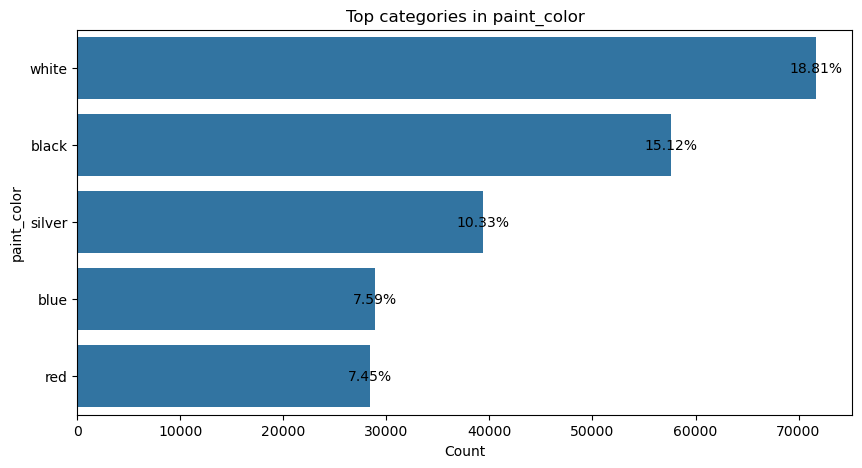

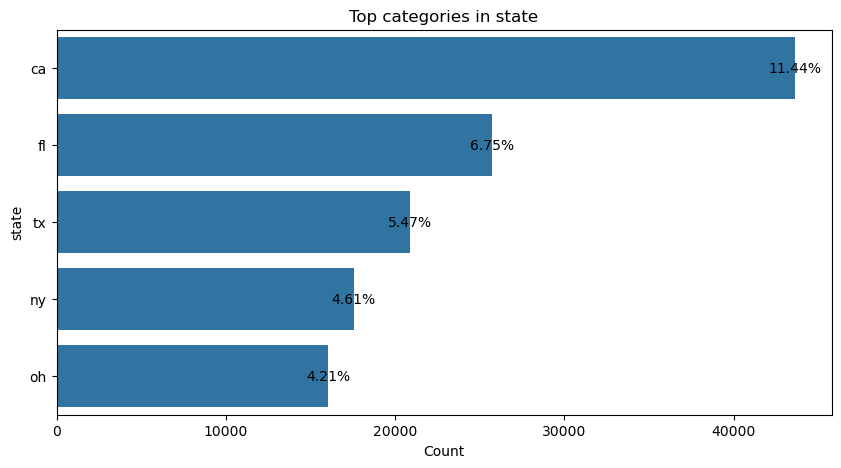

Top categories in region:
region
columbus                  3308
jacksonville              3040
omaha / council bluffs    2960
grand rapids              2910
milwaukee                 2894
Name: count, dtype: int64


Top categories in price:
price
6995    3169
7995    3129
9995    2867
8995    2837
4500    2778
Name: count, dtype: int64


Top categories in year:
year
2018.00    31205
2017.00    31068
2013.00    27342
2015.00    26918
2016.00    26435
Name: count, dtype: int64


Top categories in manufacturer:
manufacturer
ford         63358
chevrolet    49184
toyota       30705
honda        19258
nissan       16703
Name: count, dtype: int64


Top categories in model:
model
f-150             6893
silverado 1500    4395
1500              3656
silverado         2726
camry             2705
Name: count, dtype: int64


Top categories in condition:
condition
good         118315
excellent     92110
like new      19406
fair           6140
new             990
Name: count, dtype: int64


Top categ

In [56]:
#Visaul view of top categories in the dataset with percentage and get a list of all the top categories
columns = df.columns.to_list()
for col in columns:
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(y=col, data=df, order=df[col].value_counts().iloc[:5].index)

    total = len(df[col])

    for p in ax.patches:
        count = p.get_width()
        percentage = f'{100 * count / total:.2f}%'
        x = -p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height() / 2
        ax.annotate(percentage, (x, y), ha='center', va='center')
    plt.title(f'Top categories in {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.show()


for col in columns:
    top_categories = df[col].value_counts().nlargest(5)
    print(f"Top categories in {col}:")
    print(top_categories)
    print("\n")

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [57]:
'''In order to model the data we need to address the missing values in the dataset:
Percentage of missing values in each column:
size           71.77
cylinders      41.62
condition      40.79
drive          30.59
paint_color    30.50
type           21.75
manufacturer    4.13
title_status    1.93
model           1.24
odometer        1.03
fuel            0.71
transmission    0.60
year            0.28
'''
# Imputing numerical columns with median values to minimize the impact of outliers.
median_odometer = df['odometer'].median()
df['odometer'] = df['odometer'].fillna(median_odometer)

# Imputing categorical columns with mode values. With less than 5% missing values, mode imputation is unlikely to introduce bias.
for col in ['manufacturer', 'model', 'fuel', 'transmission', 'title_status']:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)

# Imputing categorical columns with high missing values with 'Unknown' to represent missing data. Due to over 20% missing values, mode imputation could generate bias.
for col in ['size', 'cylinders', 'condition', 'drive', 'paint_color', 'type']:
    df[col] = df[col].fillna('Unknown')

# Dropping rows with missing values in the 'year' column. this is the least missing value in the dataset so minimal impact
df = df.dropna(subset=['year'])

#confirming no missing values in the dataset
print("After imputing missing values:")
print(df.isnull().sum())

After imputing missing values:
region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64


In [58]:
#creating a car age rather than using the year column
current_year = 2024
df['car_age'] = current_year - df['year'] #creating a new car feature
df = df.drop(columns=['year']) #dropping the year column since we have the car age column

#also removing cars priced above a reasonable upper limit since this is too high and unrealistic
upper_limit = df['price'].quantile(0.995)
df = df[df['price'] <= upper_limit]


print(f'Dataset Summary: \n {df.describe(include='all')}') #to get a summary of the dataset

Dataset Summary: 
           region     price manufacturer   model condition cylinders    fuel    odometer title_status transmission   drive     size     type paint_color   state   car_age
count     377919 377919.00       377919  377919    377919    377919  377919   377919.00       377919       377919  377919   377919   377919      377919  377919 377919.00
unique       404       NaN           42   26766         7         9       5         NaN            6            3       4        5       14          13      51       NaN
top     columbus       NaN         ford   f-150   Unknown   Unknown     gas         NaN        clean    automatic     4wd  Unknown  Unknown     Unknown      ca       NaN
freq        3298       NaN        76735   11120    141210    154485  319481         NaN       365201       294561  115011   270876    80769      108311   43210       NaN
mean         NaN  19065.93          NaN     NaN       NaN       NaN     NaN    98654.98          NaN          NaN     NaN      NaN 

In [59]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# Identify categorical and numerical columns
categorical_cols = ['region', 'manufacturer', 'condition', 'cylinders', 'fuel', 'title_status',
                    'transmission', 'drive', 'type', 'paint_color', 'state', 'size']
numerical_cols = ['odometer', 'car_age']

# Reduce cardinality of 'region' by grouping less frequent regions into 'Other'
top_regions = df['region'].value_counts().nlargest(20).index
df['region'] = df['region'].apply(lambda x: x if x in top_regions else 'Other')

# Update categorical columns after modifying 'region'
categorical_cols = ['region', 'manufacturer', 'condition', 'cylinders', 'fuel', 'title_status',
                    'transmission', 'drive', 'type', 'paint_color', 'state', 'size']

# Prepare column transformer with OneHotEncoder for categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])

In [60]:

# Separate features and target variable
X = df.drop(['price'], axis=1)
y = df['price']

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the pipeline with preprocessing and the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=15,  # Adjusted to prevent overfitting and reduce computation time
        n_jobs=-1,     # Utilize all CPU cores
        random_state=42))
])

# Train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['odometer', 'car_age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['region', 'manufacturer',
                                                   'condition', 'cylinders',
                                                   'fuel', 'title_status',
                                                   'transmission', 'drive',
                                                   'type', 'paint_color',
                                                   'state', 'size'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=15, n_jobs=-1,
                                       random_state=42))])

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Mean Absolute Error (MAE): $3,569.31
R-squared Score: 0.8356


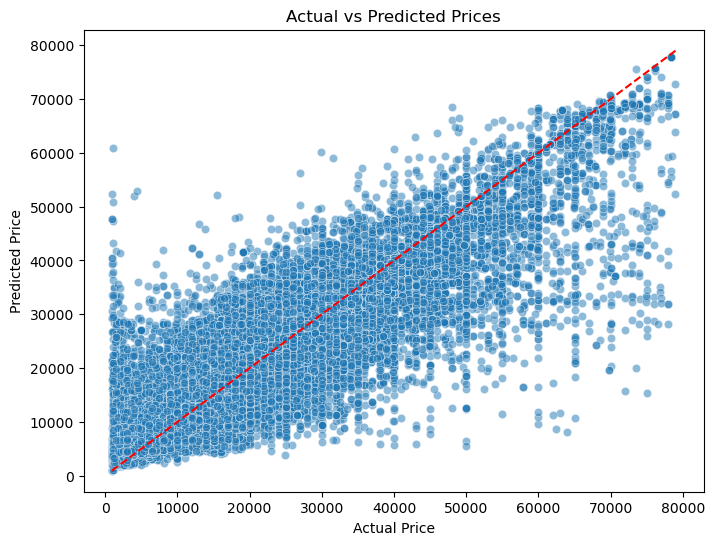

Top 20 Features by Importance:
                        feature  importance
1                       car_age        0.49
0                      odometer        0.11
97                    drive_fwd        0.09
81                  fuel_diesel        0.08
78        cylinders_8 cylinders        0.03
75        cylinders_4 cylinders        0.02
95                    drive_4wd        0.02
83                     fuel_gas        0.02
108                 type_pickup        0.01
77        cylinders_6 cylinders        0.01
96                drive_Unknown        0.01
68               condition_good        0.00
52      manufacturer_mitsubishi        0.00
110                  type_truck        0.00
49   manufacturer_mercedes-benz        0.00
65            condition_Unknown        0.00
86           title_status_clean        0.00
30       manufacturer_chevrolet        0.00
99                     type_SUV        0.00
79            cylinders_Unknown        0.00


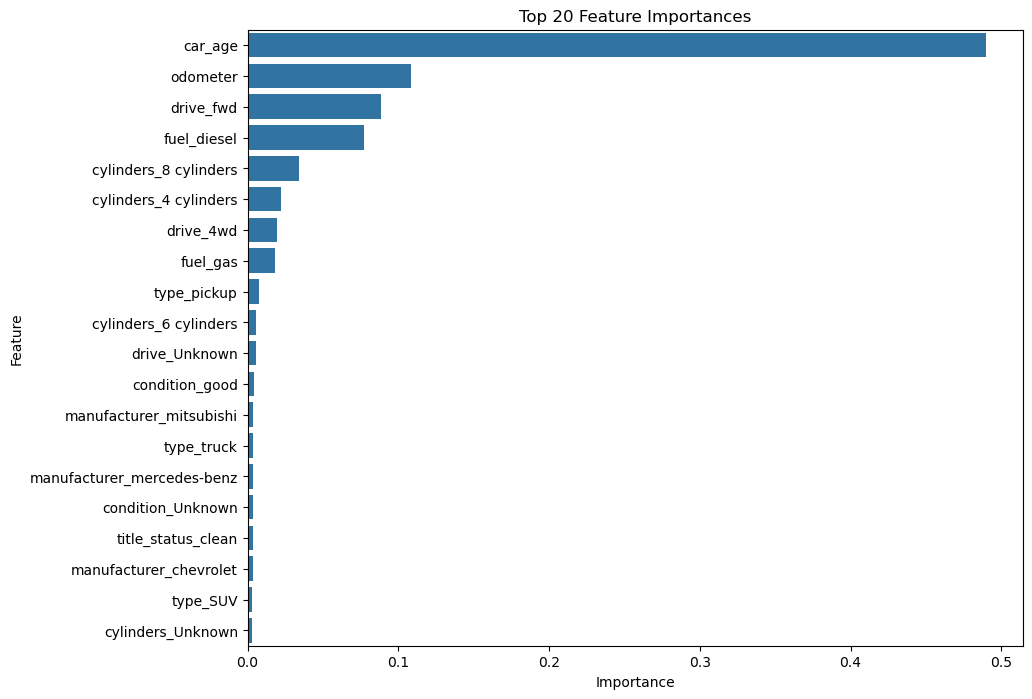

In [62]:

# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"R-squared Score: {r2:.4f}")

# Plot Actual vs Predicted Prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.show()

# Feature Importance
# Get feature names after one-hot encoding
onehot_features = model_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(onehot_features)

# Get feature importances from the model
importances = model_pipeline.named_steps['regressor'].feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
})

# Sort the features by importance
feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)

# Display the top 20 features
print("Top 20 Features by Importance:")
print(feature_importance_df.head(20))

# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

In [64]:
'''Based on analysis of the dataset, the most significant factors that influence the price of a used car are:
- Car age: Age of the car is the most significant factor that influences the price of a used car. Newer cars tend to have higher prices. 
- Odometer: The mileage of a car is also a key factor that influences the price. Cars with lower mileage tend to have higher prices.
- Drive: Cars with front-wheel drive (FWD) tend to have higher prices compared to other drive types.
- Fuel: Diesel cars tend to have higher prices compared to other fuel types.


Mean Absolute Error (MAE): $3,569.31 - 
An MAE of $3,569.31 means that, on average, the model’s price predictions are within $3,569.31 of the actual car prices. 

This is a reasonable error margin considering the range of car prices in the dataset.
R-squared Score: 0.8356

An R-squared value above 0.8 is generally considered very good in predictive modeling, indicating a strong fit between the model and the data.

                         feature  importance
1                       car_age        0.49
0                      odometer        0.11
97                    drive_fwd        0.09
81                  fuel_diesel        0.08


Relationships:
Age and Price: Inversely related; as the car age increases, the price decreases due to depreciation.
Mileage and Price: Inversely related; higher mileage reduces the car’s value.
Certain brands may retain value better due to reliability, reputation, or demand.
Better condition leads to higher prices; well-maintained cars are more desirable.



'''

'Based on analysis of the dataset, the most significant factors that influence the price of a used car are:\n- Car age: Age of the car is the most significant factor that influences the price of a used car. Newer cars tend to have higher prices. \n- Odometer: The mileage of a car is also a key factor that influences the price. Cars with lower mileage tend to have higher prices.\n- Drive: Cars with front-wheel drive (FWD) tend to have higher prices compared to other drive types.\n- Fuel: Diesel cars tend to have higher prices compared to other fuel types.\n\n\nMean Absolute Error (MAE): $3,569.31 - \nAn MAE of $3,569.31 means that, on average, the model’s price predictions are within $3,569.31 of the actual car prices. \n\nThis is a reasonable error margin considering the range of car prices in the dataset.\nR-squared Score: 0.8356\n\nAn R-squared value above 0.8 is generally considered very good in predictive modeling, indicating a strong fit between the model and the data.\n\n        

In [ ]:
'''
Recommendations:
- Focus on acquiring and selling cars with lower car ages to capitalize on higher price points.
- Seek out vehicles with lower odometer readings.
- Recognize the consumer preference for FWD cars and adjust inventory accordingly.
- Offer diesel vehicles to attract buyers interested in fuel efficiency and engine longevity.
- Adjust prices of older or high-mileage vehicles to reflect their lower market value.
- Emphasize low car age, low mileage, FWD, and diesel features in marketing materials.
- Inform potential buyers about the benefits of FWD and diesel engines to increase perceived value.

The analysis indicates that car age, mileage, drive type, and fuel type are the most significant factors 
influencing used car prices. By aligning inventory and marketing strategies with these insights, 
the dealership can better meet customer demands, optimize pricing, and improve profitability.

'''

